<a href="https://colab.research.google.com/github/aralbright/2021_AAMSME/blob/main/Differential_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential expression

In [ ]:
# Import packages and setup 

import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import diffxpy.api as de
from statsmodels.sandbox.stats.multicomp import multipletests

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

## Load adata

In [ ]:
# Load AnnData
adata = anndata.read_h5ad("/Volumes/Mac-External/insulator/results/insulator_withoutcp190_mito5_multimap_6000hvg_070521.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 8281 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [ ]:
# remove mitochondrial and ribosomal genes
riboS = adata.var["gene"].str.startswith('RpS')
riboS = riboS.astype(bool)

riboL = adata.var["gene"].str.startswith('RpL')
riboL = riboL.astype(bool)

mriboS = adata.var["gene"].str.startswith('mRpS')
mriboS = mriboS.astype(bool)

mriboL = adata.var["gene"].str.startswith('mRpL')
mriboL = mriboL.astype(bool)

mito_genes = adata.var["gene"].str.startswith('mt:')
mito_genes = mito_genes.astype(bool)

badgenes = (riboS | riboL | mito_genes | riboS | riboL)

adata = adata[:, ~badgenes]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 8281 × 5907
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

## Differential expression within each cluster

In [ ]:
adata.X = adata.layers['X_scvi_raw']

In [ ]:
clusters = sorted(adata.obs.leiden_scVI.unique())
subs = {}
tests = {}
dfs = {}
sig_dfs = {}
corr_dfs = {}

# subset adata according to cluster 
for i in clusters: 
    
    # subset adata 
    
    name = i
    subs[name] = subs.get(name, adata[adata.obs['leiden_scVI'] == i])
    
subs['bulk'] = adata
    
# for each subset adata, run t-test between control and ctcf    
for sub in subs:     
    
    # run t-test between batches 
    
    ttest = 'test_tt_{}'.format(sub)
    tests[ttest] = de.test.t_test(data = subs[sub], grouping = 'batch')
    
# for each t-test, get the summary dataframe
for test in tests: 
    
    # get summary df 
    df = 'df_{}'.format(test)
    dfs[df] = tests[test].summary()
    
    # add cluster number to a column
    dfs[df]['cluster'] = df[-1]
    
# for each dataframe, bonferroni correct the p-value and filter for significance
for df in dfs: 
    
    # adjust p value 
    
    adj = multipletests(dfs[df]['pval'], alpha = 0.05, method='bonferroni')
    dfs[df]['padj'] = adj[1]
        
    # is significant? 

    dfs[df]['is_sig'] = ((dfs[df]['padj'] <= 0.05) & (abs(dfs[df]['log2fc']) >= 1.5))
       
    # filter for significance     
    
    sig_dfs[df] = dfs[df].loc[dfs[df]['is_sig'] == True]

    
for sig in sig_dfs: 
    
    # add cluster number as column 
    #sig_dfs[sig]['cluster'] = sig[-1]
    
    # correct the p-value for the number of upset comparisons
    sig_dfs[sig]['pcorr'] = (sig_dfs[sig]['padj'] * (len(clusters) + 1))
    
    # filter for significance into a final dictionary of genes to plot
    corr_dfs[sig] = sig_dfs[sig][(sig_dfs[sig]['pcorr'] <= 0.05)]

/Users/aralbright/opt/anaconda3/envs/scvi-env/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aralbright/opt/anaconda3/envs/scvi-env/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aralbright/opt/anaconda3/envs/scvi-env/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [ ]:
# merge all dfs in corr_dfs into one df 

frames = corr_dfs.values()

In [ ]:
df_to_plot = pd.concat(frames)

In [ ]:
dfs

{'df_test_tt_0':                      gene           pval           qval    log2fc       mean  \
 0                 CG40635   4.676817e-01   4.847509e-01 -0.105133   0.001280   
 1          lncRNA:CR40719   2.508771e-01   2.659603e-01  0.103866   0.003439   
 2                    Adhr   2.458712e-04   3.016326e-04  0.287170   0.000796   
 3                 CG11929   2.275379e-35   5.692786e-35  0.905756   0.043366   
 4                   Elba3   2.465595e-01   2.614770e-01 -0.064288   0.505565   
 ...                   ...            ...            ...       ...        ...   
 5902              CR41506   1.615351e-18   2.859419e-18  0.874719   0.005255   
 5903  28SrRNA-Psi:CR40596   6.049552e-77   3.665098e-76  0.911441   2.203203   
 5904      28SrRNA:CR45837  9.705981e-116  1.786082e-114  1.093261   8.438697   
 5905     pre-rRNA:CR45846  3.157275e-242  1.865002e-238  2.210233  52.731906   
 5906      28SrRNA:CR45844   4.267437e-73   2.336214e-72  0.746571  13.123617   
 
       zer

## Volcano Plot

In [ ]:
for df in dfs: 
    
    dfs[df]['volcano_y'] = -np.log10(dfs[df]['padj'])
    

/Users/aralbright/opt/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
locals().update(dfs)

In [ ]:
dfs.keys()

dict_keys(['df_test_tt_0', 'df_test_tt_1', 'df_test_tt_2', 'df_test_tt_3', 'df_test_tt_4', 'df_test_tt_5', 'df_test_tt_6', 'df_test_tt_7', 'df_test_tt_8', 'df_test_tt_9', 'df_test_tt_bulk'])

Cluster 0

In [ ]:
xs = df_test_tt_0['log2fc']
ys = df_test_tt_0['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

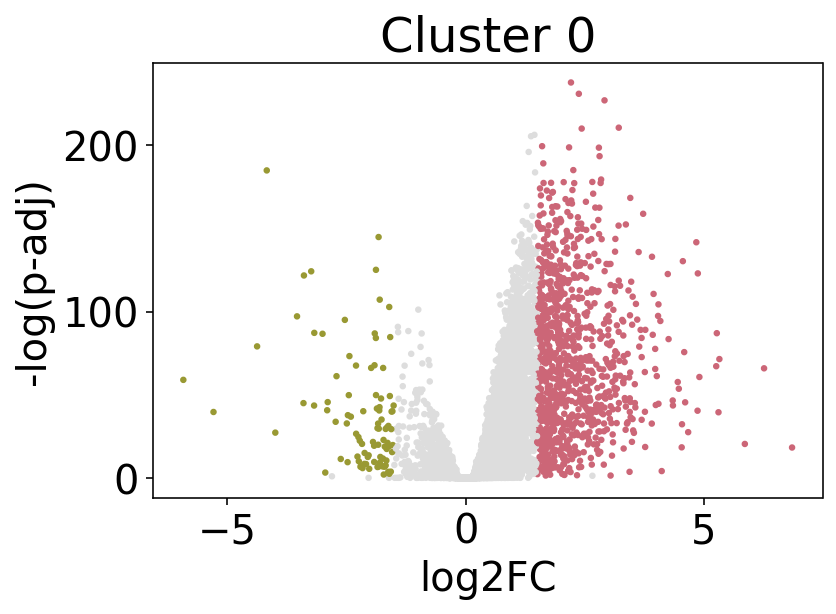

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 0')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 1

In [ ]:
xs = df_test_tt_1['log2fc']
ys = df_test_tt_1['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

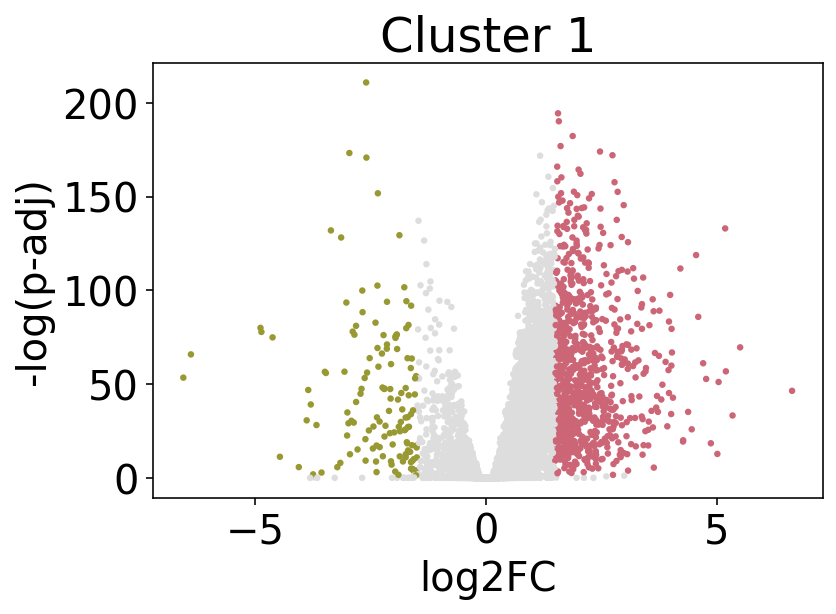

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 1')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 2

In [ ]:
xs = df_test_tt_2['log2fc']
ys = df_test_tt_2['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

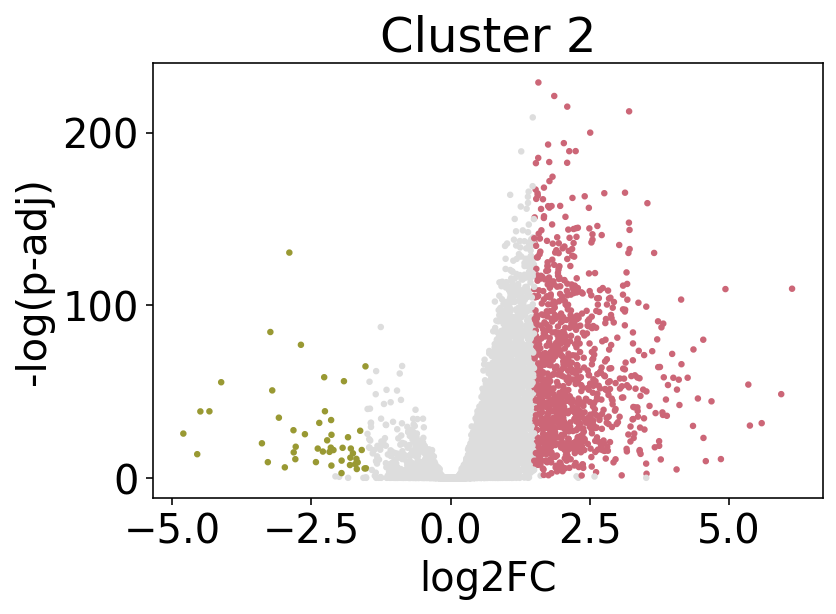

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 2')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 3

In [ ]:
xs = df_test_tt_3['log2fc']
ys = df_test_tt_3['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

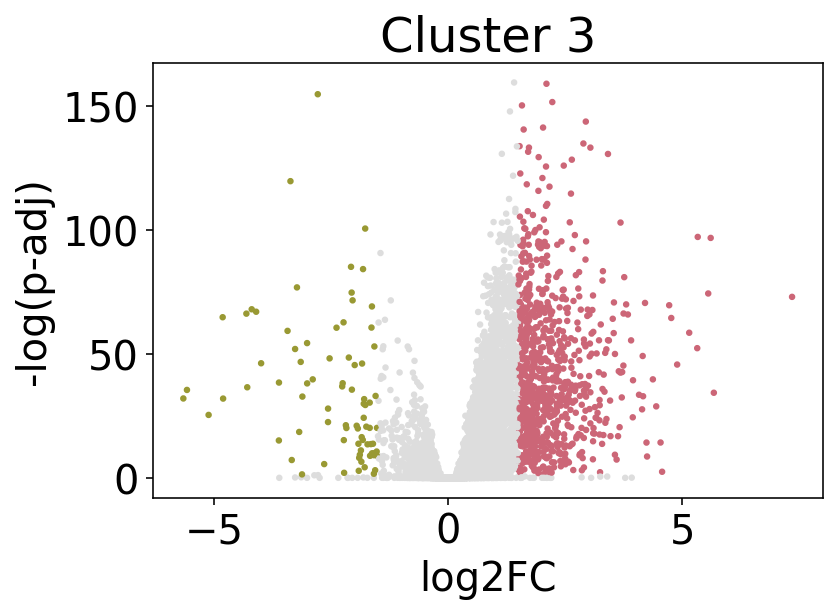

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 3')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 4

In [ ]:
xs = df_test_tt_4['log2fc']
ys = df_test_tt_4['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

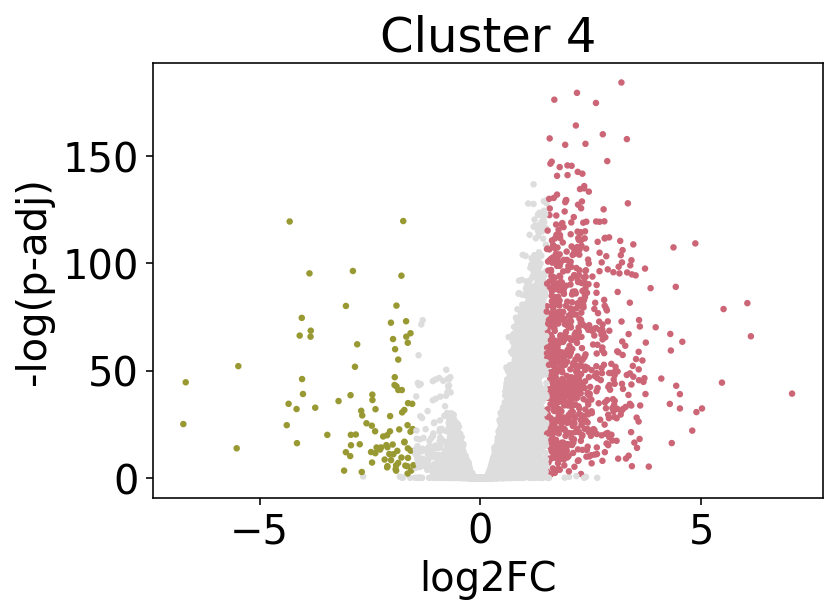

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 4')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 5

In [ ]:
xs = df_test_tt_5['log2fc']
ys = df_test_tt_5['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

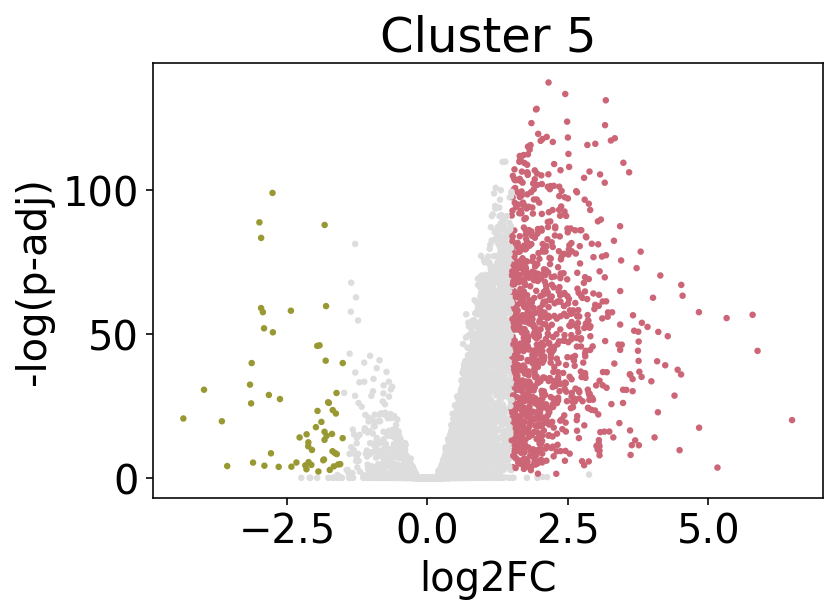

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 5')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 6

In [ ]:
xs = df_test_tt_6['log2fc']
ys = df_test_tt_6['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

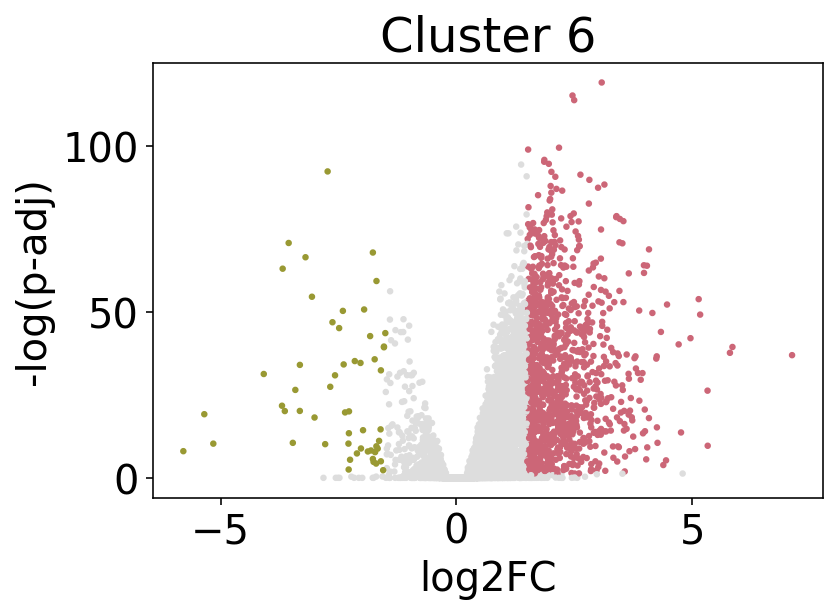

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 6')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 7

In [ ]:
xs = df_test_tt_7['log2fc']
ys = df_test_tt_7['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

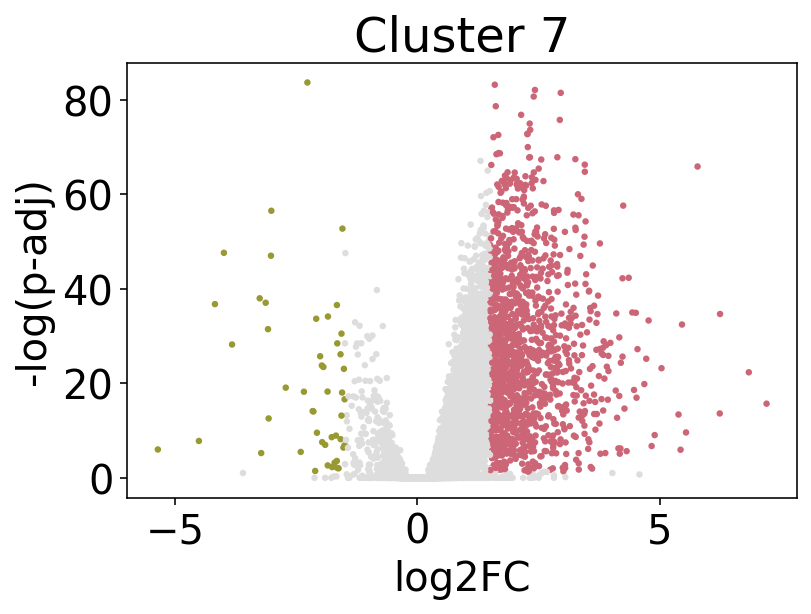

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 7')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 8

In [ ]:
xs = df_test_tt_8['log2fc']
ys = df_test_tt_8['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

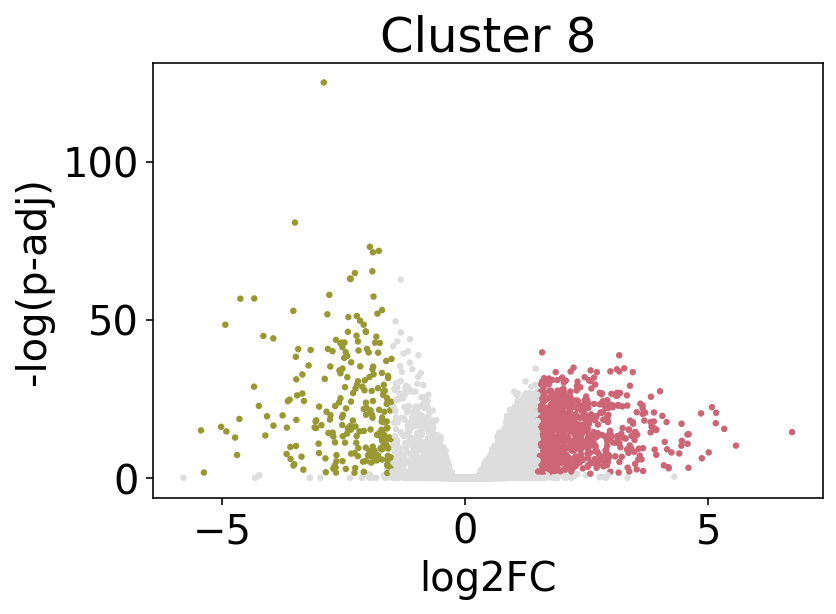

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 8')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Cluster 9

In [ ]:
xs = df_test_tt_9['log2fc']
ys = df_test_tt_9['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

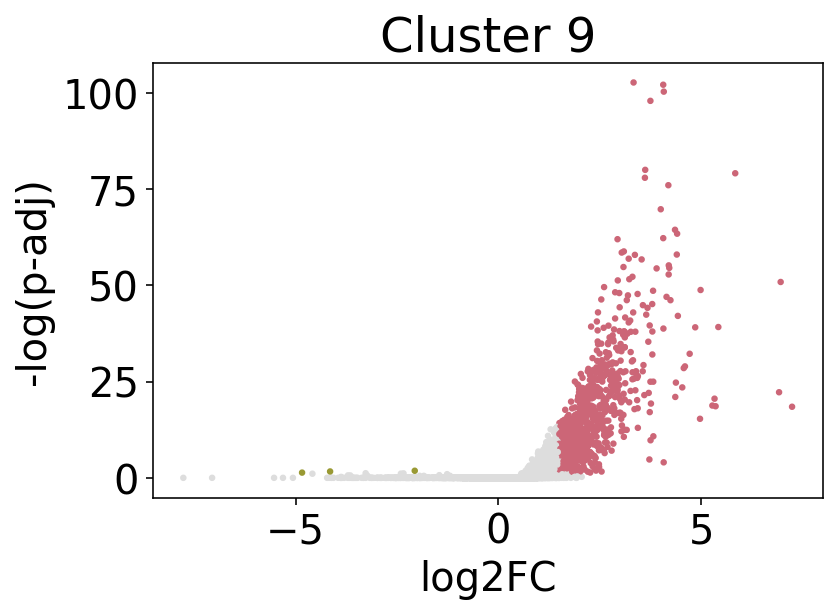

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 9')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

Bulk

In [ ]:
xs = df_test_tt_bulk['log2fc']
ys = df_test_tt_bulk['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

Text(0, 0.5, '-log(p-adj)')

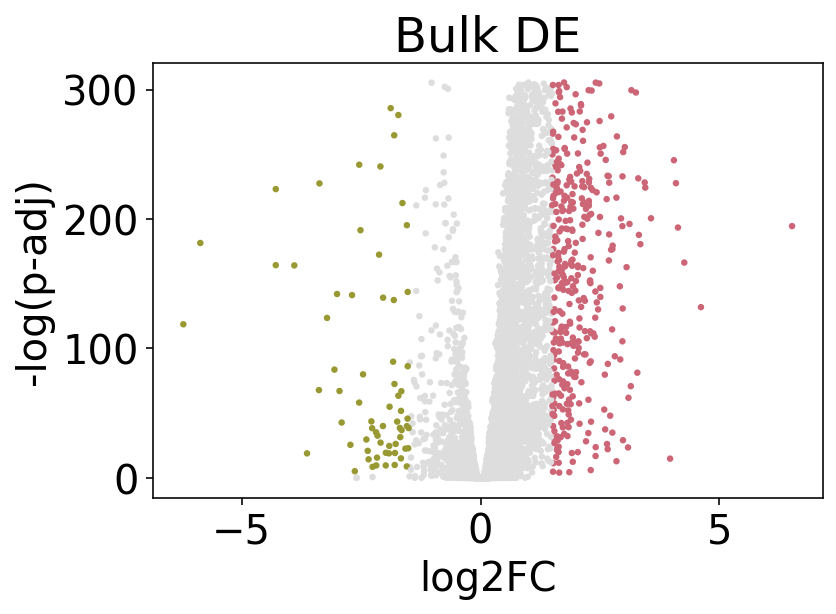

In [ ]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Bulk DE')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')

## Save df_to_plot for UpSetR

In [ ]:
df_to_plot

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,pcorr
14,mxt,2.104691e-176,4.604596e-174,1.830767,0.100097,False,False,0,1.243241e-172,True,1.367565e-171
20,Atet,1.042348e-82,7.151161e-82,2.385228,0.092474,False,False,0,6.157149e-79,True,6.772864e-78
22,Tps1,6.802026e-85,4.948223e-84,1.957373,0.010894,False,False,0,4.017957e-81,True,4.419753e-80
23,l(2)k05819,1.071063e-100,1.194670e-99,1.695711,0.057052,False,False,0,6.326768e-97,True,6.959445e-96
27,ND-B8,1.653687e-93,1.507458e-92,1.982809,0.007420,False,False,0,9.768327e-90,True,1.074516e-88
...,...,...,...,...,...,...,...,...,...,...,...
5881,xmas,0.000000e+00,0.000000e+00,1.842541,0.056012,False,False,k,0.000000e+00,True,0.000000e+00
5883,CR46425,0.000000e+00,0.000000e+00,3.334538,0.002681,False,False,k,0.000000e+00,True,0.000000e+00
5885,Ir7g,8.437118e-109,2.109994e-108,1.969864,0.010306,False,False,k,4.983806e-105,True,5.482186e-104
5890,Su(Ste):CR42428,2.365853e-131,6.705899e-131,1.712831,0.004411,False,False,k,1.397509e-127,True,1.537260e-126


In [ ]:
df_to_plot.to_csv('deGenesDF.csv')

## Single Gene Plots

In [ ]:
adata.X = adata.layers['norm_log_unscaled']

In [ ]:
adata.obs['batch'] = adata.obs['batch'].replace({'0':'control', '1':'ctcf'})

Trying to set attribute `.obs` of view, copying.


In [ ]:
gene = 'mnd'

Text(0.5, 1.0, 'mnd')

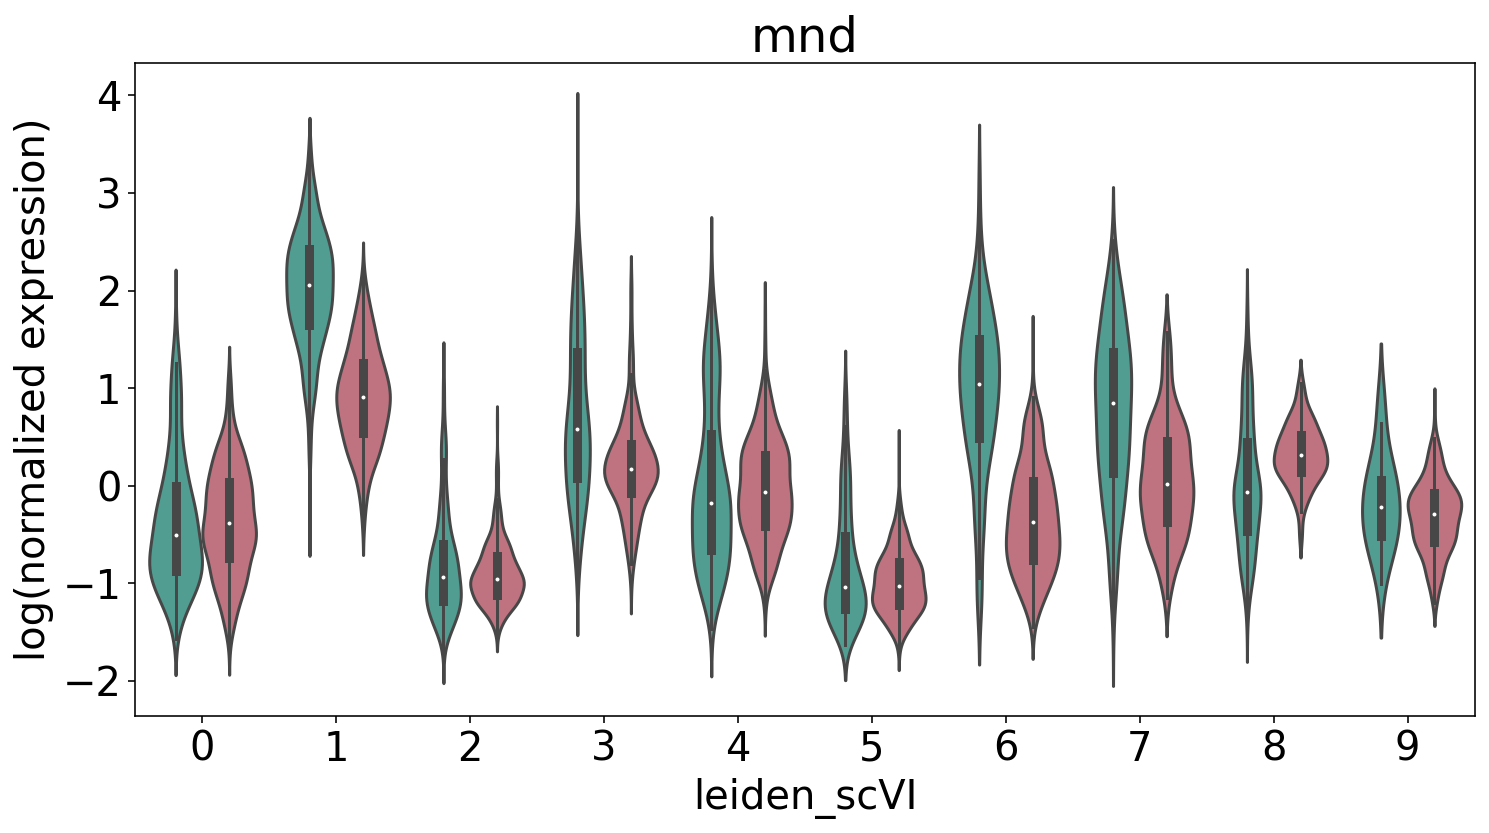

In [ ]:
x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'mnd')

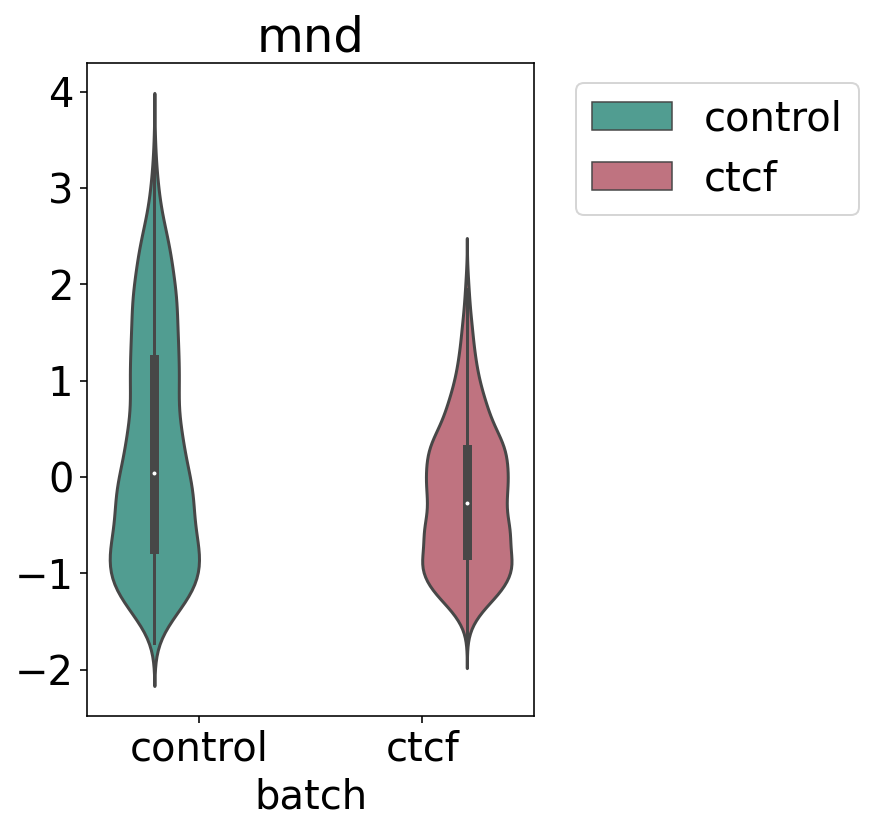

In [ ]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [ ]:
bootydo[bootydo['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig
2689,mnd,1.509568e-01,1.625710e-01,-0.076425,1.821538,False,False,0,1.000000e+00,False
2689,mnd,2.017225e-157,4.137412e-156,-1.133703,8.268650,False,False,1,1.191575e-153,False
2689,mnd,4.913578e-06,6.907307e-06,-0.269405,1.006237,False,False,2,2.902450e-02,False
2689,mnd,3.939632e-29,1.186711e-28,-0.747414,3.799619,False,False,3,2.327141e-25,False
2689,mnd,6.276552e-04,7.682468e-04,-0.221590,2.531868,False,False,4,1.000000e+00,False
2689,mnd,7.559581e-09,1.192057e-08,-0.444409,0.959794,False,False,5,4.465445e-05,False
2689,mnd,2.060116e-50,1.263666e-49,-1.626184,3.338855,False,False,6,1.216910e-46,True
2689,mnd,5.458367e-27,1.540496e-26,-0.886774,3.807761,False,False,7,3.224257e-23,False
2689,mnd,2.162024e-05,2.948760e-05,0.249008,2.686165,False,False,8,1.277108e-01,False
2689,mnd,1.592719e-01,1.995374e-01,-0.254085,1.772714,False,False,9,1.000000e+00,False


In [ ]:
df_to_plot.loc[df_to_plot['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,padj,is_sig,cluster,pcorr
183,ush,2.429017e-17,1.209798e-16,-1.715047,0.492173,False,False,1.434820e-13,True,8,1.578302e-12


In [ ]:
adata[:,~adata.var.gene.isin(list(singleDE['gene']) or list(multiDE['gene']))]

View of AnnData object with n_obs × n_vars = 8281 × 5253
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [ ]:
poop = pd.DataFrame(df_to_plot['gene'].value_counts())

In [ ]:
poop

,gene
CG44439,11
CG31176,11
CR46425,11
Fas1,11
CG11459,11
...,...
Hayan,1
ftz,1
E(spl)mdelta-HLH,1
EMC5,1


In [ ]:
poop = list(poop[poop['gene'] == 1].index)

In [ ]:
poop

['Aldh-III',
 'CR41501',
 'shu',
 'VhaM9.7-a',
 'snoRNA:U3:54Aa',
 'CG9338',
 'CG9220',
 'lncRNA:CR44575',
 'CG43702',
 'CR40461',
 'Ada3',
 'Ca-Ma2d',
 'CG3618',
 'Nbr',
 'lncRNA:CR45502',
 'CG6870',
 'CG42854',
 'sug',
 'CG13954',
 'CG14864',
 'Pgant2',
 'CG13088',
 'BBS9',
 'CG32206',
 'pkaap',
 'Jhe',
 'Gip',
 'CG32032',
 'CG3566',
 'CG31103',
 'CG10616',
 'lncRNA:CR44697',
 'lncRNA:CR44084',
 'CG31279',
 'CG42495',
 'toy',
 'Oseg2',
 'Sema5c',
 'Sxl',
 'bnb',
 'comt',
 'rgr',
 'CG11103',
 'Egm',
 'Lerp',
 'mthl8',
 'lncRNA:CR45361',
 'disco-r',
 'CG3356',
 'CG44422',
 'Pcyt2',
 'CG3663',
 'gcm',
 'lncRNA:CR44584',
 'Alg10',
 'shot',
 'CG13920',
 'CG13014',
 'ND-B8',
 'Idgf3',
 'CG18262',
 'Not10',
 'nemy',
 'asRNA:CR45907',
 'Rep',
 'CG13699',
 'Dll',
 'CG9992',
 'CG12964',
 'CG9657',
 'CG17896',
 'upd1',
 'mRpS29',
 'Vajk4',
 'scrt',
 'Ae2',
 'Pkcdelta',
 'Gpo1',
 'kek2',
 'dpr1',
 'Osi17',
 'AP-1mu',
 'Pde6',
 'Sesn',
 'BORCS5',
 'Sugb',
 'Sec10',
 'Ublcp1',
 'aop',
 'Nse1',
 'C

In [ ]:
singleDE = df_to_plot.loc[df_to_plot['gene'].isin(poop)]

In [ ]:
singleDE

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,pcorr
27,ND-B8,5.874361e-87,3.252094e-86,1.533659,0.035490,False,False,0,3.469985e-83,True,3.816983e-82
58,CG31777,1.394979e-67,5.486113e-67,2.020810,0.031226,False,False,0,8.240141e-64,True,9.064155e-63
190,rempA,4.330010e-48,1.232050e-47,1.551166,0.017647,False,False,0,2.557737e-44,True,2.813511e-43
566,CG5945,2.553563e-71,1.066754e-70,1.681213,0.029158,False,False,0,1.508390e-67,True,1.659229e-66
620,CG31775,3.586415e-16,5.840902e-16,-1.609815,0.032116,False,False,0,2.118495e-12,True,2.330345e-11
...,...,...,...,...,...,...,...,...,...,...,...
5654,CG12237,3.614602e-11,3.147559e-10,-1.588425,0.298808,False,False,9,2.135145e-07,True,2.348660e-06
5768,CG12541,1.138031e-26,4.201470e-25,1.938177,3.773492,False,False,9,6.722352e-23,True,7.394587e-22
5853,lncRNA:CR45502,6.136214e-11,5.155991e-10,2.431208,0.011500,False,False,9,3.624661e-07,True,3.987128e-06
1881,ana,4.425725e-09,5.477217e-09,-1.541775,0.034834,False,False,k,2.614276e-05,True,2.875703e-04


In [ ]:
multiDE = df_to_plot.loc[~df_to_plot['gene'].isin(poop)]

In [ ]:
len(multiDE['gene'].unique())

1404

In [ ]:
len(singleDE['gene'].unique())

695

In [ ]:
len(adata.X.mean(axis=0))

5907

In [ ]:
poop

['Aldh-III',
 'CR41501',
 'shu',
 'VhaM9.7-a',
 'snoRNA:U3:54Aa',
 'CG9338',
 'CG9220',
 'lncRNA:CR44575',
 'CG43702',
 'CR40461',
 'Ada3',
 'Ca-Ma2d',
 'CG3618',
 'Nbr',
 'lncRNA:CR45502',
 'CG6870',
 'CG42854',
 'sug',
 'CG13954',
 'CG14864',
 'Pgant2',
 'CG13088',
 'BBS9',
 'CG32206',
 'pkaap',
 'Jhe',
 'Gip',
 'CG32032',
 'CG3566',
 'CG31103',
 'CG10616',
 'lncRNA:CR44697',
 'lncRNA:CR44084',
 'CG31279',
 'CG42495',
 'toy',
 'Oseg2',
 'Sema5c',
 'Sxl',
 'bnb',
 'comt',
 'rgr',
 'CG11103',
 'Egm',
 'Lerp',
 'mthl8',
 'lncRNA:CR45361',
 'disco-r',
 'CG3356',
 'CG44422',
 'Pcyt2',
 'CG3663',
 'gcm',
 'lncRNA:CR44584',
 'Alg10',
 'shot',
 'CG13920',
 'CG13014',
 'ND-B8',
 'Idgf3',
 'CG18262',
 'Not10',
 'nemy',
 'asRNA:CR45907',
 'Rep',
 'CG13699',
 'Dll',
 'CG9992',
 'CG12964',
 'CG9657',
 'CG17896',
 'upd1',
 'mRpS29',
 'Vajk4',
 'scrt',
 'Ae2',
 'Pkcdelta',
 'Gpo1',
 'kek2',
 'dpr1',
 'Osi17',
 'AP-1mu',
 'Pde6',
 'Sesn',
 'BORCS5',
 'Sugb',
 'Sec10',
 'Ublcp1',
 'aop',
 'Nse1',
 'C

In [ ]:
multiDE

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,pcorr
20,Atet,2.621835e-98,1.736231e-97,1.904235,0.414536,False,False,0,1.548718e-94,True,1.703590e-93
28,ine,8.383108e-84,4.386095e-83,2.204284,0.020279,False,False,0,4.951902e-80,True,5.447092e-79
38,CG2955,2.612038e-42,6.764274e-42,1.597711,0.010476,False,False,0,1.542931e-38,True,1.697224e-37
43,bark,6.983984e-68,2.761338e-67,1.998690,0.025869,False,False,0,4.125439e-64,True,4.537983e-63
49,capu,6.811883e-198,3.529631e-196,2.737678,0.517303,False,False,0,4.023779e-194,True,4.426157e-193
...,...,...,...,...,...,...,...,...,...,...,...
5870,CG15375,1.389012e-108,3.333968e-108,1.646623,0.013336,False,False,k,8.204896e-105,True,9.025386e-104
5872,lncRNA:CR32652,1.729415e-82,3.614880e-82,-2.143613,0.011130,False,False,k,1.021565e-78,True,1.123722e-77
5880,upd2,8.994587e-297,4.552787e-296,2.532001,0.177886,False,False,k,5.313103e-293,True,5.844413e-292
5883,CR46425,8.866113e-246,3.740866e-245,3.109308,0.015899,False,False,k,5.237213e-242,True,5.760934e-241


In [ ]:
notDE = adata[:,~adata.var.gene.isin(poop)]

In [ ]:
single_adata = adata[:,adata.var.gene.isin(list(singleDE['gene']))]

In [ ]:
multi_adata = adata[:, adata.var.gene.isin(list(multiDE['gene']))]

In [ ]:
single_adata.X = single_adata.layers['X_scvi_norm']

In [ ]:
singleDE_list = list(single_adata.var.gene)

In [ ]:
multiDE_list = list(multi_adata.var.gene)

In [ ]:
notDE_list = list(notDE.var.gene)

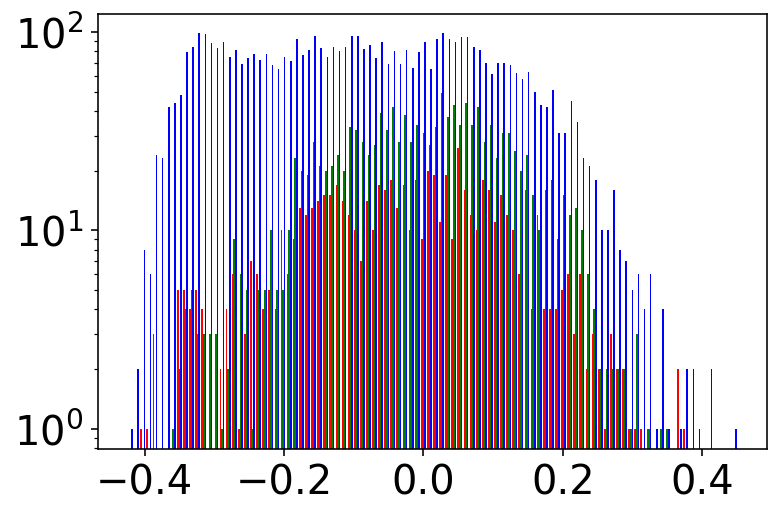

In [ ]:
plt.figure()
plt.hist([single_adata.X.mean(axis=0), multi_adata.X.mean(axis=0), notDE.X.mean(axis=0)], color = ['red', 'green', 'blue'], bins = 100)
plt.yscale('log')

In [ ]:
x = singleDE['mean']
y = multiDE['mean']
z = notDE.X.mean(axis=0)

In [ ]:
import seaborn as sns

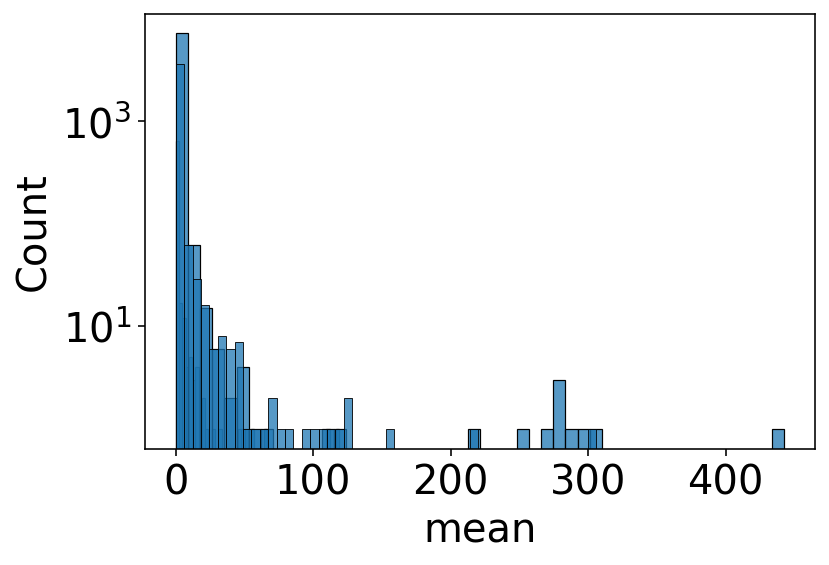

In [ ]:
fig, ax = plt.subplots()
for a in [x, y, z]:
    sns.histplot(a, bins=50, ax=ax, kde=False)
    plt.yscale("log")
plt.show()

In [ ]:
sns.histplot([x, y, z], bins = 50, ax = ax)

NameError: name 'z' is not defined

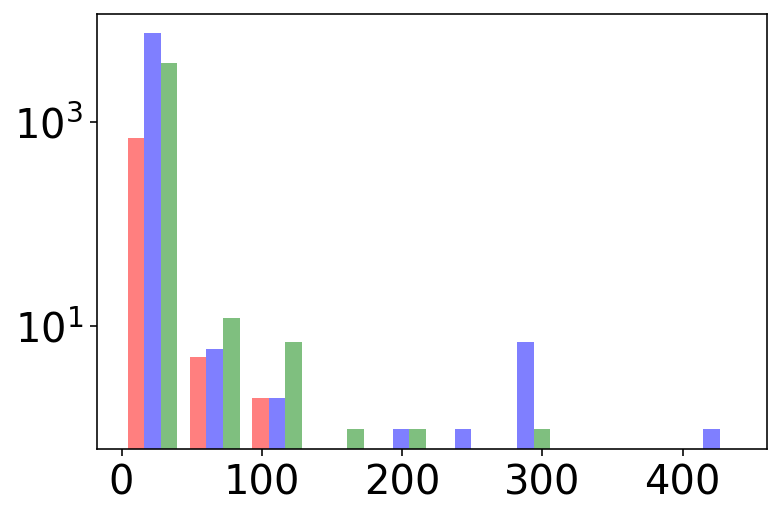

In [ ]:
plt.hist([x, y, z], color=['r','b','g'], alpha=0.5)
plt.yscale('log')

In [ ]:
notDE = adata[:,~adata.var.gene.isin(list(singleDE['gene']) and list(multiDE['gene']))]

In [ ]:
len(multiDE['gene'].unique())

1404

In [ ]:
multiDE

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,pcorr
20,Atet,2.621835e-98,1.736231e-97,1.904235,0.414536,False,False,0,1.548718e-94,True,1.703590e-93
28,ine,8.383108e-84,4.386095e-83,2.204284,0.020279,False,False,0,4.951902e-80,True,5.447092e-79
38,CG2955,2.612038e-42,6.764274e-42,1.597711,0.010476,False,False,0,1.542931e-38,True,1.697224e-37
43,bark,6.983984e-68,2.761338e-67,1.998690,0.025869,False,False,0,4.125439e-64,True,4.537983e-63
49,capu,6.811883e-198,3.529631e-196,2.737678,0.517303,False,False,0,4.023779e-194,True,4.426157e-193
...,...,...,...,...,...,...,...,...,...,...,...
5870,CG15375,1.389012e-108,3.333968e-108,1.646623,0.013336,False,False,k,8.204896e-105,True,9.025386e-104
5872,lncRNA:CR32652,1.729415e-82,3.614880e-82,-2.143613,0.011130,False,False,k,1.021565e-78,True,1.123722e-77
5880,upd2,8.994587e-297,4.552787e-296,2.532001,0.177886,False,False,k,5.313103e-293,True,5.844413e-292
5883,CR46425,8.866113e-246,3.740866e-245,3.109308,0.015899,False,False,k,5.237213e-242,True,5.760934e-241


In [ ]:
multiDE.drop_duplicates('gene')

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,padj,is_sig,cluster,pcorr
14,mxt,2.104691e-176,4.604596e-174,1.830767,0.100097,False,False,1.243241e-172,True,0,1.367565e-171
20,Atet,1.042348e-82,7.151161e-82,2.385228,0.092474,False,False,6.157149e-79,True,0,6.772864e-78
22,Tps1,6.802026e-85,4.948223e-84,1.957373,0.010894,False,False,4.017957e-81,True,0,4.419753e-80
23,l(2)k05819,1.071063e-100,1.194670e-99,1.695711,0.057052,False,False,6.326768e-97,True,0,6.959445e-96
27,ND-B8,1.653687e-93,1.507458e-92,1.982809,0.007420,False,False,9.768327e-90,True,0,1.074516e-88
...,...,...,...,...,...,...,...,...,...,...,...
4887,lncRNA:CR45594,8.233294e-19,4.815254e-18,-2.725592,0.012987,False,False,4.863407e-15,True,8,5.349747e-14
5239,Es2,3.272748e-23,3.356272e-22,1.563110,0.010266,False,False,1.933212e-19,True,8,2.126534e-18
5300,CG2972,2.105551e-18,1.180027e-17,1.660066,0.036916,False,False,1.243749e-14,True,8,1.368124e-13
5575,Ubr1,3.966135e-32,1.541313e-30,2.291974,1.709995,False,False,2.342796e-28,True,8,2.577076e-27


In [ ]:
notDE = bootydo[~bootydo.gene.isin(single_list or multi_list)]

In [ ]:
notDE = notDE.drop_duplicates('gene')

In [ ]:
sum(notDE["is_sig"] == False)

4184

In [ ]:
single_list = list(singleDE['gene'])
multi_list = list(multiDE['gene'])

In [ ]:
len(single_list)

654

In [ ]:
singleDE[singleDE['cluster'] == "6"].to_csv('DE_6only.csv')

In [ ]:
singleDE[singleDE['cluster'] == "6"]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,padj,is_sig,cluster,pcorr
30,Gs1l,4.586552e-31,2.286309e-30,1.597083,0.010949,False,False,2.709276e-27,True,6,2.980204e-26
175,PGAP2,2.209464e-43,2.139558e-42,1.804063,0.040472,False,False,1.305131e-39,True,6,1.435644e-38
257,Kr-h2,9.967080e-49,1.317221e-47,1.615412,0.026670,False,False,5.887554e-45,True,6,6.476310e-44
379,CG13392,9.815668e-59,2.600052e-57,1.661488,0.035706,False,False,5.798115e-55,True,6,6.377926e-54
388,CG9568,1.995317e-17,5.229076e-17,1.520653,0.002378,False,False,1.178634e-13,True,6,1.296497e-12
...,...,...,...,...,...,...,...,...,...,...,...
4703,CG6567,4.252406e-48,5.390335e-47,-1.509411,0.008776,False,False,2.511896e-44,True,6,2.763086e-43
4955,CG17896,4.290384e-25,1.621452e-24,2.122881,0.000728,False,False,2.534330e-21,True,6,2.787763e-20
5162,CG3842,2.559671e-31,1.295628e-30,1.514283,0.012246,False,False,1.511998e-27,True,6,1.663197e-26
5271,CG15370,1.208919e-13,2.662968e-13,2.155126,0.002851,False,False,7.141086e-10,True,6,7.855195e-09


In [ ]:
gene = 'gd'

Text(0.5, 1.0, 'gd')

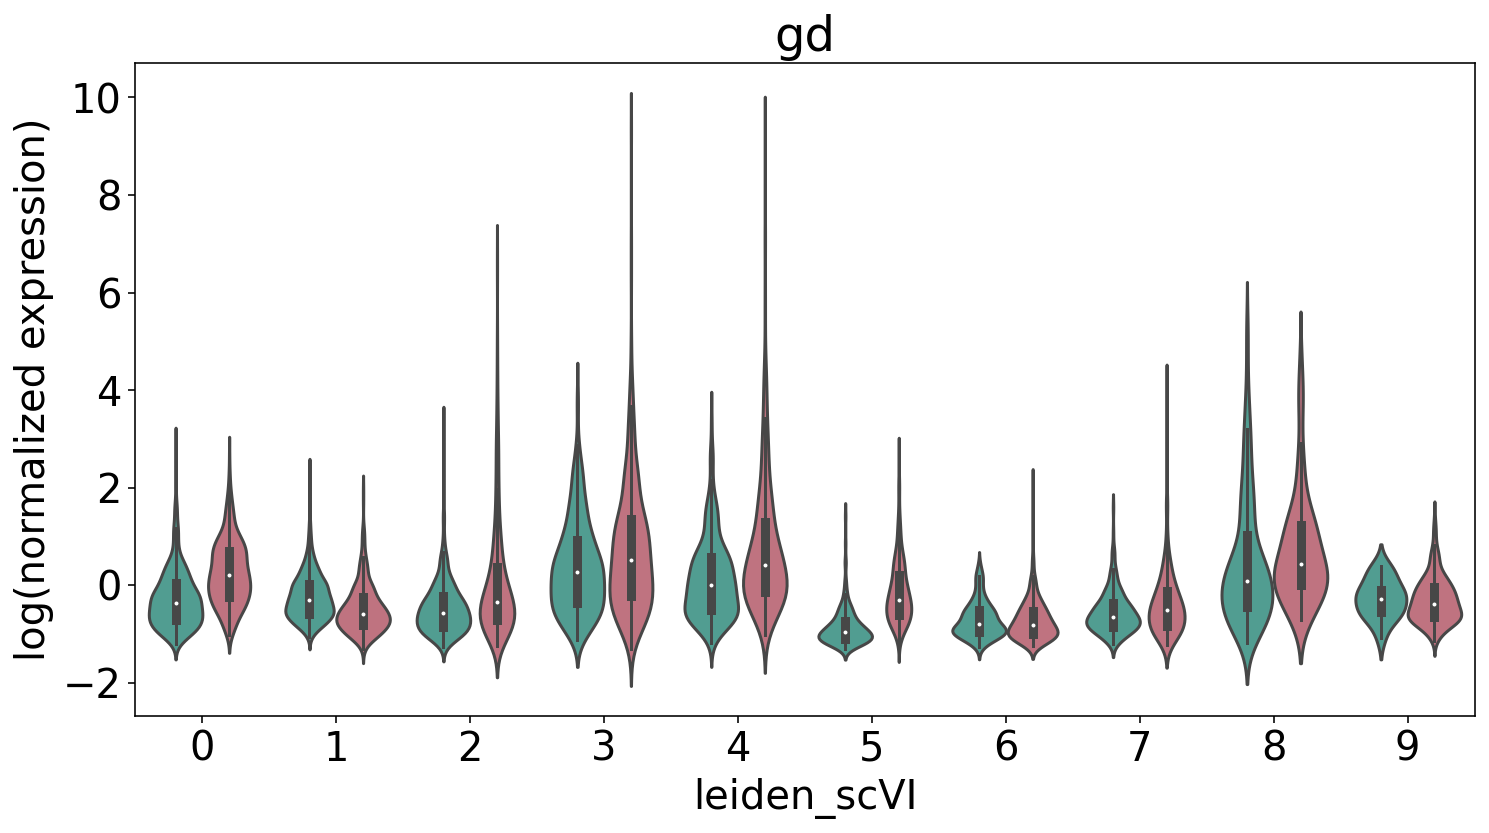

In [ ]:
x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'gd')

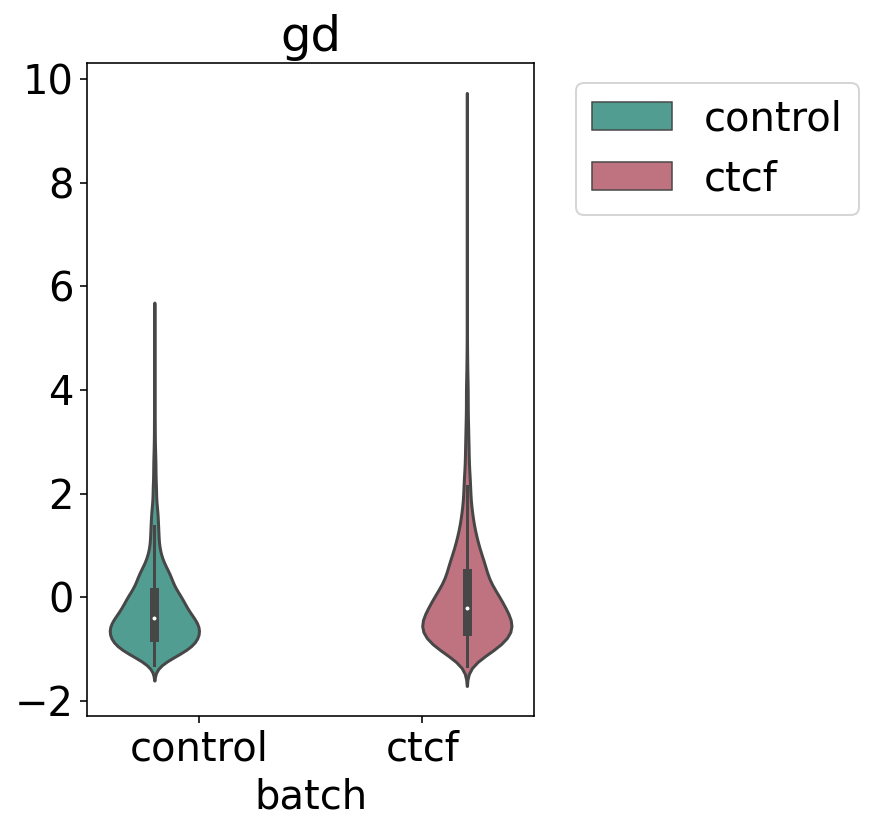

In [ ]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [ ]:
df_to_plot.loc[df_to_plot['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,padj,is_sig,cluster,pcorr
5810,gd,3.454181e-78,6.201778e-77,1.926426,0.00968,False,False,2.040385e-74,True,5,2.244423e-73


In [ ]:
notDE = adata

In [ ]:
single

NameError: name 'singleDE' is not defined

In [ ]:
single = adata[:,adata.var.gene.isin(singleDE_list)]

In [ ]:
multi = adata[:,adata.var.gene.isin(multiDE_list)]

In [ ]:
notDE = adata[:,adata.var.gene.isin(notDE_list)]

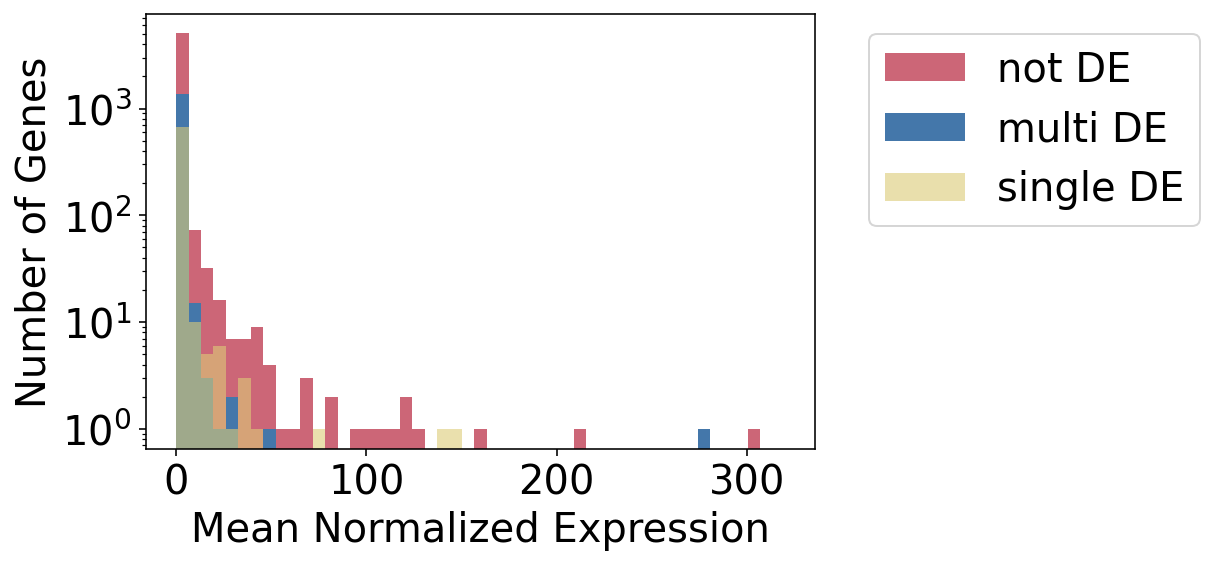

In [ ]:
bins = np.linspace(0,320, 50)

fig, ax = plt.subplots()

plt.hist(notDE.X.mean(axis=0), bins = bins, color = '#CC6677', alpha = 1, label = 'not DE')
plt.hist(multi.X.mean(axis=0), bins = bins, color = '#4477AA', alpha = 1, label = 'multi DE')
plt.hist(single.X.mean(axis=0), bins = bins, color = '#DDCC77', alpha = 0.6, label = 'single DE')

ax.set_xlabel('Mean Normalized Expression')
ax.set_ylabel('Number of Genes')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc = "upper left")
plt.yscale('log')

In [ ]:
booty = dfs.values()

In [ ]:
dfs.keys()

dict_keys(['df_test_tt_0', 'df_test_tt_1', 'df_test_tt_2', 'df_test_tt_3', 'df_test_tt_4', 'df_test_tt_5', 'df_test_tt_6', 'df_test_tt_7', 'df_test_tt_8', 'df_test_tt_9', 'df_test_tt_bulk'])

In [ ]:
bootydo = pd.concat(booty)

In [ ]:
bootydo.loc[bootydo['gene'] == gene]

NameError: name 'gene' is not defined